# Monte Carlo Risk Simulation of a Stock Portfolio: 

##  1. Importing and preprocessing data: 

### Importing dependencies

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf

In [72]:
stock_list = ['LSTA', 'EHI', 'BDRY', 'PCH', 'DAO', 'AVGO', 'MLYS', 'ALG', 'SHLD']
end = dt.datetime.now()
start = end - dt.timedelta(days = 300)

''' 
This functions, takes the list of stocks in the portfolio and the start and end date for the 
historical data and 
'''

def processed_data (stocks, start, end): 
    stock_data = yf.download(stocks, start, end, auto_adjust=False)['Close']
    log_returns = (np.log(stock_data) - np.log(stock_data.shift(1))).dropna()
    mean_returns = log_returns.mean()  
    cov_matrix = log_returns.cov()
    return  cov_matrix, log_returns, mean_returns


cov_matrix, log_returns, mean_returns =processed_data(stock_list, start, end)

[*********************100%***********************]  9 of 9 completed


## 2. Portfolio Construction:  

In [73]:
# Assigning random weights to the assets. 
weights = np.random.random(len(mean_returns)) 
weights /= np.sum(weights) # Makes sure that the sum of all the weights is equals to 1. 

# Number of Simuations.
mc_sims = 1000

#Time duration of simulations.
Time = 100

# Initialising mean_mat, which is the matrix of mean returns of each asset.
mean_mat  = np.full(shape=(Time, len(weights)), fill_value=mean_returns)
mean_mat = mean_mat.T # creates transpose of mean returns

# Initial amount invested in the portfolio.  
initial_portfolio = 10000

# Initalises portfolio matrix, an empty matrix that will later record each simulation.
portfolio_simulations = np.full(shape= (Time, mc_sims), fill_value = 0.0)


## 3. Cholesky Decompostion and Monte-Carlo Simullation:

### Why Cholesky Decomposition?

In a multi-asset portfolio, asset returns are correlated and hence not independent. To simulate realistic future return scenarios, it's essential to preserve the correlation structure between assets. Cholesky decomposition provides an efficient and mathematically sound way to do this.


### 3.1. Cholesky Decomposition

Given a **positive semi-definite** covariance matrix $\Sigma$, Cholesky decomposition gives:

$$
\Sigma = LL^\top
$$

where:
- $L$ is a lower triangular matrix
- $L^\top$ is its transpose

This is used to simulate **correlated asset returns** in a Monte Carlo setting.

We generate standard normal random variables $Z \sim \mathcal{N}(0, I)$, then transform them using:

$$
R = \mu + LZ
$$

Where:
- $L = \text{Cholesky}(\Sigma)$
- $\mu$ is the vector of expected returns
- $R$ is the simulated return vector with desired correlations


This transforms the i.i.d. standard normal samples $Z$ into **correlated asset returns** $R$ that match the historical covariance matrix $\Sigma$.

Therfore, it allows us to:
- Generate Realistic mutivariate return paths
- Ensures the simulated portfolio behaves like historical data
- Preserves the co-movement between sectors or assets, which will be later useful in stress scenarios.  

### 3.2. Why Monte Carlo?

In a financial context, Monte Carlo simulation enables us to generate thousands of possible future outcomes for a portfolio by sampling from a **distribution of returns**  incorporating both mean expectations and correlation structure between assets. 

This technique is widely used in banks, hedge funds, asset management firms and credit rating firms to estimate potential losses and exposure under uncertain market conditions. It provides a way to forecast what could happen, not just what has happened.

In this project we assume that the returns have normal distritbution, despite its limitations, normality is still used in practice, especially in initial stages of risk modeling including VaR calculations, portfolio optimization, and many regulatory frameworks (e.g., Basel II/III standardized approaches)


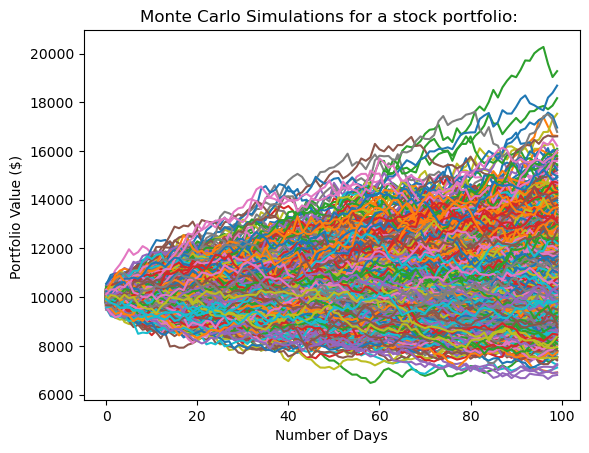

In [74]:
np.random.seed(42)
for m in range(0, mc_sims):
    ''' This runs and updates the Portfolio Matrix by multiplying the 
    Lower Triangular Matrix "L" from Choslesky decompostion with Normal dist. "Z" 
    which later gets added to the mean returns matrix or mean matrix (mean_mat)'''


    Z = np.random.normal(size= (Time, len(weights)))
    L = np.linalg.cholesky(cov_matrix)
    daily_retruns = mean_mat + np.inner(L,Z)
    
     # this updates the portfolio simsulations matrix on each run.
    portfolio_simulations[:,m] = np.cumprod(np.inner(weights, daily_retruns.T)+1)*initial_portfolio 

plt.plot(portfolio_simulations)
plt.ylabel('Portfolio Value ($) ')
plt.xlabel('Number of Days')
plt.title('Monte Carlo Simulations for a stock portfolio: ')
plt.show()


    

Now we can see the all possible outcomes of the portoflio plotted in the graph, but still we don't know much about the distribution of the returns at the end of the time period.

## 4. Risk Metrics: 

### 4.1. Value at Risk (VaR)

Value at Risk at confidence level $\alpha$ is the quantile of the loss distribution:

$$
\text{VaR}_\alpha = \inf \{ x \in \mathbb{R} : P(L > x) \leq 1 - \alpha \}
$$

For empirical (simulated) returns:

$$
\text{VaR}_\alpha = \text{Quantile}_{1 - \alpha}(R)
$$

Where:
- $R$ is the distribution of simulated returns
- $\alpha$ is the confidence level (e.g., 0.95 for 95% VaR)


In [75]:
def mc_var (return_series, alpha = 5): #alpha = 5 is the 5th percentile. 
    """ Input: Pandas return series
    Output: Percentile distribution to a given confidence level of alpha"""

    if isinstance(return_series, pd.Series):
        return np.percentile(return_series, alpha) # returns the 5th percentile of the reutrn_series' distribution
    else: 
        raise TypeError("Expected pd data series")

### 4.2. Conditional Value at Risk (CVaR)

CVaR (Expected Shortfall) at confidence level $\alpha$ is the average return in the worst $\alpha \cdot 100\%$ of cases:

$$
\text{CVaR}_\alpha = \frac{1}{N_\alpha} \sum_{i=1}^{N} R_i \quad \text{such that} \quad R_i \leq \text{VaR}_\alpha
$$

Where:
- $N_\alpha$ is the number of simulated returns less than or equal to $\text{VaR}_\alpha$
- Returns $R_i$ are sorted or filtered based on the VaR threshold



In [76]:
def mc_cvar(return_series, alpha=5):
    """ Input: pd data series
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(return_series, pd.Series):
        #here we check every instance, where the return of the mc_var function is less than the return series and capture it in below_var
        below_var = return_series <= mc_var(return_series, alpha = alpha) 
         
        return return_series[below_var].mean() #gives us the expected shortfall below the threshold of alpha=5
    else: 
        raise TypeError("Expected pd data series")


## 5. Plotting porfolio simulations: 

VaR ($) 1557.36
CVaR ($) 2152.25


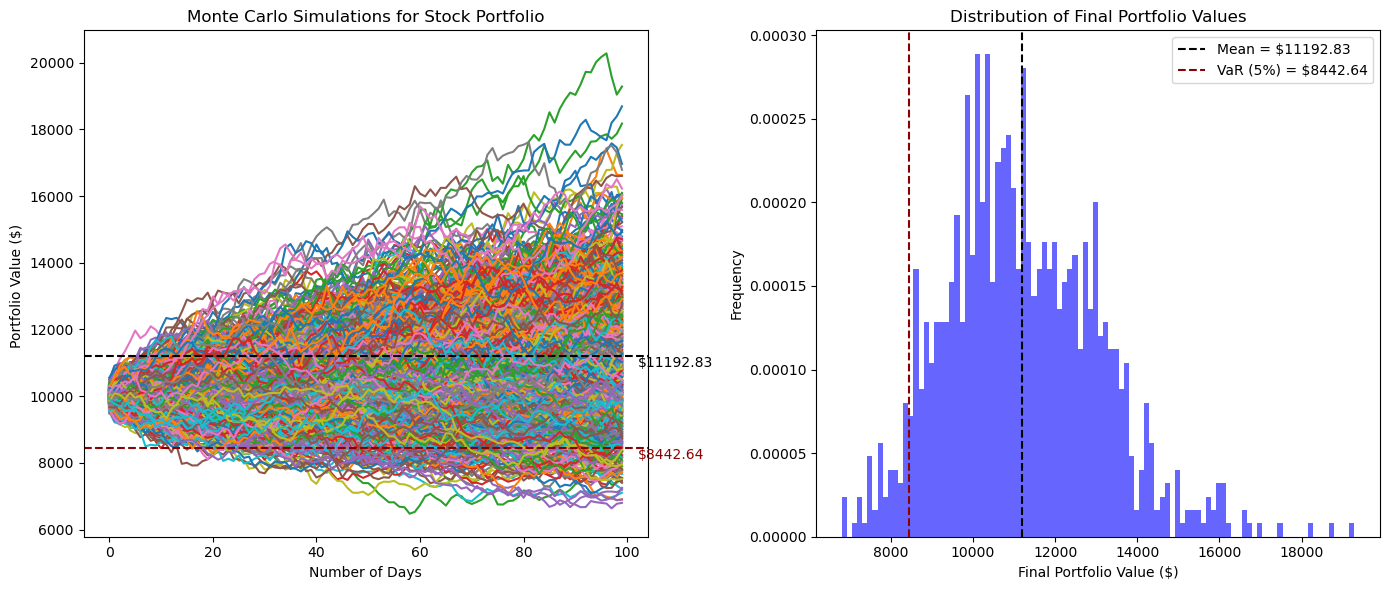

In [77]:
def mc_plots(port_sim):
    port_res = pd.Series(port_sim[-1, :])
    var = initial_portfolio - mc_var(port_res, alpha=5)
    cvar = initial_portfolio- mc_cvar(port_res, alpha=5)

    print("VaR ($) {}".format(round(var, 2)))
    print("CVaR ($) {}".format(round(cvar, 2)))

    mean_value = port_res.mean()
    pct_value= mc_var(port_res, alpha=5)

    #subplots: 
    fig ,axes = plt.subplots(1,2, figsize=(14,6))

    #plotting Monte-Carlo Simulations: 
    axes[0].plot(port_sim)
    axes[0].set_title('Monte Carlo Simulations for Stock Portfolio')
    axes[0].set_ylabel('Portfolio Value ($) ')
    axes[0].set_xlabel('Number of Days')
    axes[0].axhline(mean_value, color='black', linestyle = "--", label = f'Mean = ${mean_value:.2f}')
    axes[0].axhline(pct_value, color = 'darkred', linestyle = "--", label = f'VaR (5%) = ${pct_value:.2f}')
    axes[0].text(Time+2, mean_value, f"${mean_value:.2f}", color = 'black', va = 'top')
    axes[0].text(Time+2, pct_value, f"${pct_value:.2f}", color = 'darkred', va='top')

    #plotting Histogram of the Final output:
    axes[1].hist(port_res, bins = 100, density= True, alpha = 0.6, color = 'blue')
    axes[1].set_ylabel('Frequency')
    axes[1].set_xlabel('Final Portfolio Value ($)')
    axes[1].set_title('Distribution of Final Portfolio Values')
    axes[1].axvline(mean_value, color='black', linestyle = "--", label = f'Mean = ${mean_value:.2f}')
    axes[1].axvline(pct_value, color = 'darkred', linestyle = "--", label = f'VaR (5%) = ${pct_value:.2f}')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


mc_plots(portfolio_simulations)

**Left**: Simulated portfolio value paths over a 100-day horizon using 1,000 Monte Carlo runs. The black dashed line represents the mean final portfolio value ($11,192.83), and the red dashed line marks the 5% Value at Risk (VaR) threshold ($8,442.64).

**Right**: Distribution of final portfolio values. The left tail quantifies downside risk, where Conditional Value at Risk (CVaR) lies below the 5% threshold. This histogram highlights the expected portfolio exposure under adverse conditions.

## 6. Stress Testing: 

### 6.1. Negative Sentiment Scenario: 

#### Scenario Analysis: Negative Sentiment Shock to 'DAO'

To model the effect of market pessimism or asset-specific negative sentiment, we reduced the expected return of the `DAO` asset by 0.001 (i.e., -10 bps per day).

This reflects a scenario where the asset underperforms due to:
- Regulatory news
- Sector-specific downturn
- Negative earnings or macro pressure


This scenario lets us observe how a mild but persistent shock to a single asset can affect the overall portfolio's distribution, especially its downside risk.



VaR ($) 1748.5
CVaR ($) 2246.58


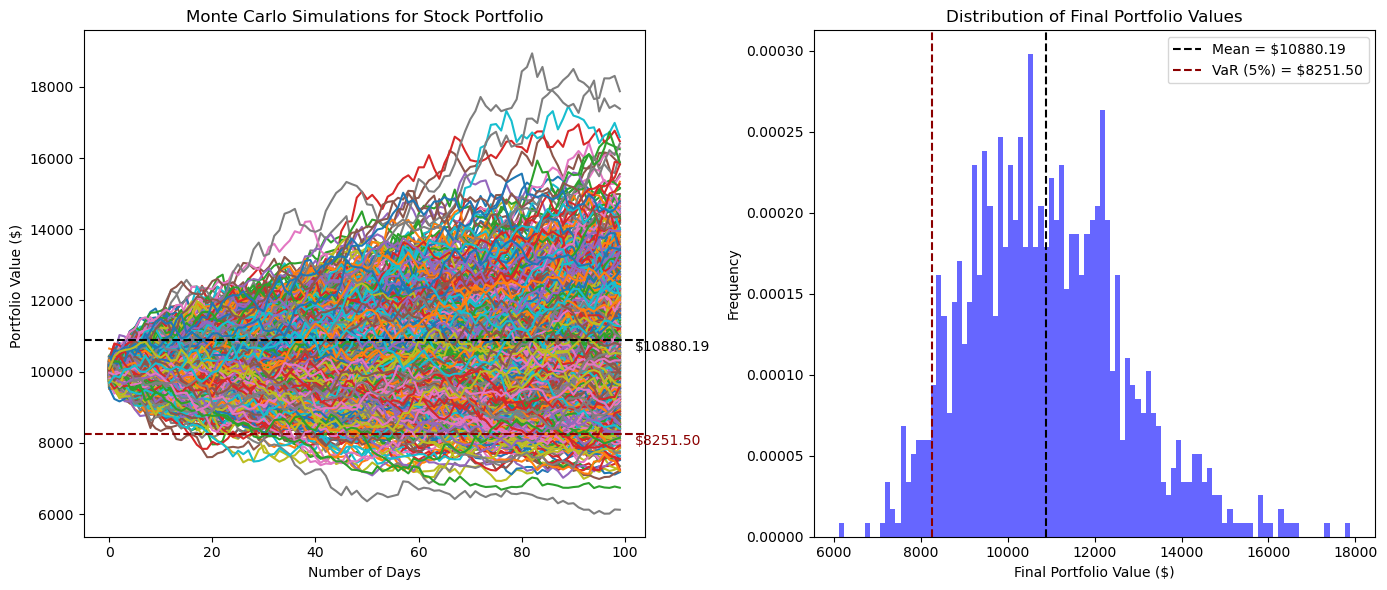

In [78]:
ns_returns = mean_returns.copy()
ns_returns['DAO'] -= 0.001
mean_mat  = np.full(shape=(Time, len(weights)), fill_value=ns_returns)
mean_mat = mean_mat.T # creates transpose of mean returns

portfolio_simulations = np.full(shape= (Time, mc_sims), fill_value = 0.0)

np.random.seed(101)
for m in range(0, mc_sims):
    
    Z = np.random.normal(size= (Time, len(weights)))
    L = np.linalg.cholesky(cov_matrix)
    daily_retruns = mean_mat + np.inner(L,Z)
    
     # this updates the portfolio simsulations matrix on each run.
    portfolio_simulations[:,m] = np.cumprod(np.inner(weights, daily_retruns.T)+1)*initial_portfolio 



mc_plots(portfolio_simulations)



**Figure: Negative Sentiment Shock in Monte Carlo Portfolio Simulation**

Left: Simulated portfolio trajectories over 100 trading days, incorporating a one-time negative sentiment shock. A mild downward adjustment to expected returns reflects pessimistic market expectations. The black dashed line shows the mean final portfolio value ($10,880.19), while the red dashed line marks the Value at Risk (VaR) at the 5% level ($8,251.50).

Right: Histogram of final portfolio values. The leftward shift in the distribution's tail reflects increased downside risk due to sentiment deterioration. This scenario helps investors assess exposure under moderate but widespread market pessimism.

### 6.2.  One time shock:

In this scenario, suppose that we introduce a 5% shock in one of the asset ( Western Asset Global High Income Fund or 'EHI')  at the beggining of each simulation. This scenario informs us what could be the expected value and shortfall of our portfolio given a 5% shock to the value of EHI today. 

#### Scenario Analysis: One-Time -5% Shock to 'EHI' at Day 1

To test the portfolio's resilience to a sudden, asset-specific shock, we introduced a -5% return shock to the `'EHI'` asset on the first day of each simulation path.



This models a scenario where a sudden negative event (e.g., downgrade, default scare, regulatory action) hits one specific asset at the beginning of the investment period.

It allows us to evaluate how a single-day, asset-level event can ripple through the portfolio.



VaR ($) 1863.18
CVaR ($) 2364.06


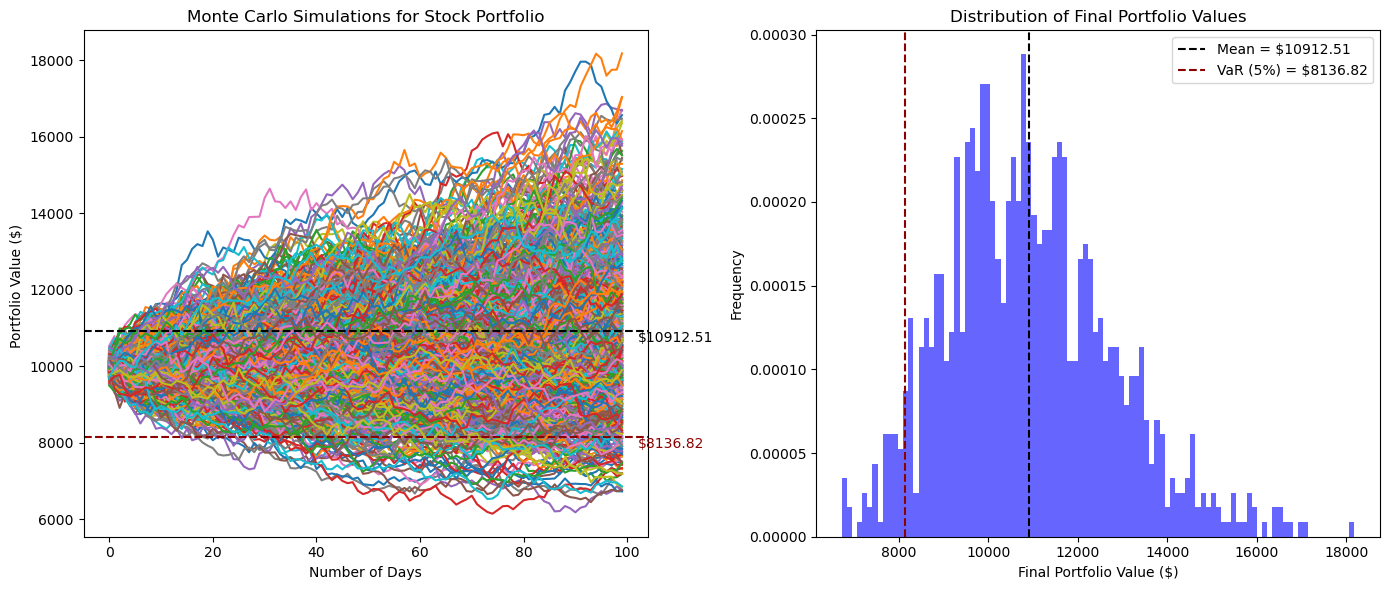

In [79]:
portfolio_simulations = np.full(shape= (Time, mc_sims), fill_value = 0.0)

ehi_index = list(log_returns.columns).index('EHI') 

np.random.seed(43)
for m in range(0, mc_sims):
    
    Z = np.random.normal(size= (Time, len(weights)))
    L = np.linalg.cholesky(cov_matrix)
    
    daily_retruns = mean_mat + np.inner(L,Z)
    daily_retruns[0, ehi_index] -= 0.05  # introducing -5% shock at the beginning of each portfolio of 'EHI'
    
     # this updates the portfolio simsulations matrix on each run.
    portfolio_simulations[:,m] = np.cumprod(np.inner(weights, daily_retruns.T)+1)*initial_portfolio 



mc_plots(portfolio_simulations)

**Figure: One-Time Shock Scenario in Monte Carlo Portfolio Simulation**

Left: Portfolio value simulations over 100 trading days, incorporating a one-time negative shock to a single asset (e.g., a -5% drop on day 1). This event reflects sudden adverse news or localized market disruption. The black dashed line marks the average final portfolio value ($10,912.51), while the red dashed line indicates the 5% Value at Risk (VaR) threshold ($8,136.82).

Right: Distribution of final portfolio values. The histogram shows modest leftward skew due to the initial shock, illustrating how localized stress can modestly increase downside risk without fully destabilizing the portfolio.

### 6.3. Crisis Mode: 

To stress test the portfolio under a systemic crisis, we ran Monte Carlo simulations using a covariance matrix scaled by 4× its historical values. We reduce the time duration down to **20 days** instead of 100 days as volatility is not persistently high and it represents a moderate level crisis. 

This reflects periods of:
- Extreme volatility (e.g. bank collapses, debt ceiling panic)
- Increased asset co-movement (contagion)
- Structural market breakdowns

#### Observations:
- Mean portfolio value remains closer its inital value, but VaR(5%) falls even lower in the range of $6,500-$8,500
- The final portfolio value distribution shows **fatter left tails** and **reduced upside concentration**
- Indicates that in crisis regimes, downside risk amplifies dramatically, and recovery paths become rarer

Such scenario analysis helps identify how vulnerable a portfolio is to systemic events and whether current allocations offer enough downside protection.

VaR ($) 1923.06
CVaR ($) 2344.99


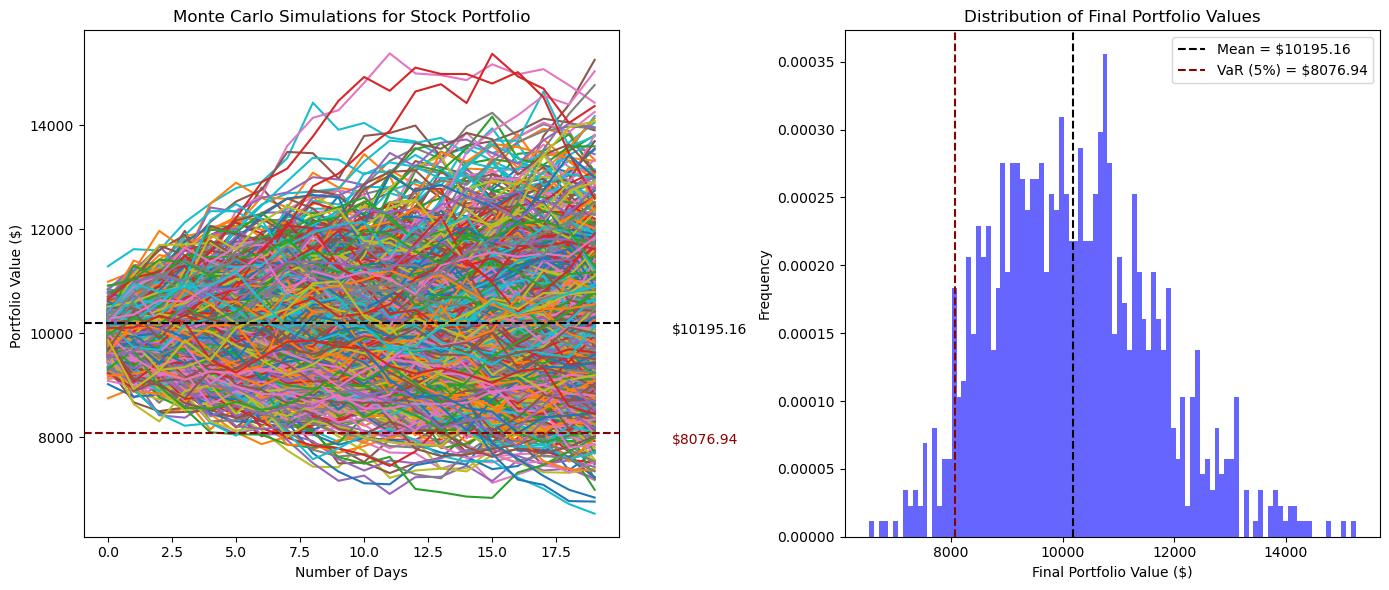

In [80]:
mc_sims = 1000
Time =20 # 1 month of trading days
portfolio_simulations = np.full(shape= (Time, mc_sims), fill_value = 0.0)

mean_mat  = np.full(shape=(Time, len(weights)), fill_value=mean_returns)
mean_mat = mean_mat.T

crisis_cov = cov_matrix.copy()
crisis_cov = crisis_cov*4

np.random.seed(44)
for m in range(0, mc_sims):

    Z = np.random.normal(size= (Time, len(weights)))
    L = np.linalg.cholesky(crisis_cov)
    daily_retruns = mean_mat + np.inner(L,Z)
    
    
    portfolio_simulations[:,m] = np.cumprod(np.inner(weights, daily_retruns.T)+1)*initial_portfolio


mc_plots(portfolio_simulations)


**Figure: Crisis Mode Scenario in Monte Carlo Portfolio Simulation**

Left: Portfolio value projections over a shortened 20-day horizon, simulating a market crisis characterized by a sharp surge in volatility. The covariance matrix is scaled to represent heightened systemic risk and cross-asset co-movement. The black dashed line shows the mean portfolio value ($10,195.16), while the red dashed line indicates the 5% Value at Risk (VaR) level ($8,076.94).

Right: The final value distribution exhibits a visibly heavier left tail, reflecting elevated downside risk. This scenario mimics periods of financial stress (e.g., 2008 GFC, COVID crash onset), where volatility spikes and correlations across assets tighten that results in amplified portfolio vulnerability.

## 7. Conclusion

This project was a demonstration of how Monte Carlo Simulations can be used to model and quantify risk in a financial portfolio or an asset. At its core, Monte Carlo is a numerical method that leverages random sampling to approximate solutions to complex problems. It is useful in situations involving uncertainty and probabilistic behavior.

Using Monte Carlo, we applied it to stress test three different scenario commmon in the stock market: 
1. **Negative Sentiment** - Price of one of the assets starts to go down in terms of daily returns due to bearish sentiment. 
2. **One Time Shock** - When in each scenairio, one of the assets in the portfolio is expected to experince a shock in its price. 
3. **Crisis mode** - When there's periods of uncertainity in the market, leading to higher volatility. 


While powerful, this simulation approach is not without limitations:

- Our model assumes **static portfolio weights**, meaning we do not adjust allocations based on volatility, return, or market regime changes.
- We do not implement dynamic risk parity, which is a more robust allocation strategy that adjusts weights to equalize the risk contribution of each asset based on volatility.
- Our simulation assumes a constant volatility and correlation structure, which may not hold during market stress (volatility clustering, tail dependence, regime shifts, etc.).
- We assume a normal distribution of the returns, but that may not neccesarily be the case. In real world markets that is not the case. 



Even with these limitations, Monte Carlo simulation offers a practical and insightful framework for understanding portfolio risk.
